# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [2]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1410,5504,50456,NaN,17-03-2020,"@MissMagickal23 In pleasant contrast, we have ...",Positive
17142,24662,69614,"Agawam, MA",25-03-2020,With new state guidelines on how grocery store...,Negative
27933,38046,82998,"Ile-de-France, France",08-04-2020,Every department store in America has tried so...,Negative
29230,39666,84618,#Australia #Oceania,09-04-2020,"@FelipeJainMD Made note last week, after obser...",Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [4]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ('Positive', 'Extremely Positive') else 0)
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
5015,9900,54852,NaN,19-03-2020,Me but with different wipes and sanitizers goi...,0
16843,24307,69259,Aqui Contigo. Here With you.,25-03-2020,continues amid the pandemic despite the potent...,0
25307,34795,79747,England,06-04-2020,Just been shopping to the supermarket.\r\r\n\r...,0
3194,7665,52617,UK,18-03-2020,"Sainsburys, tesco and Waitrose have zero colle...",0


Сбалансированы ли классы?

In [5]:
print(df['Sentiment'].value_counts())

Sentiment
1    18046
0    15398
Name: count, dtype: int64


**Ответ:** Классы сбалансированы достаточно, но не идеально

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [6]:
print("Missing data in columns before fill:")
for i in df.head():
    print(i, df[i].isna().sum())
for i in df.head():
    df[i].fillna("Unknown", inplace=True)
print("Missing data in columns after fill:")
for i in df.head():
    print(i, df[i].isna().sum())

Missing data in columns before fill:
UserName 0
ScreenName 0
Location 7049
TweetAt 0
OriginalTweet 0
Sentiment 0
Missing data in columns after fill:
UserName 0
ScreenName 0
Location 0
TweetAt 0
OriginalTweet 0
Sentiment 0


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['Sentiment'], random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [8]:
from collections import Counter

words = []
print(df["OriginalTweet"].head(5))

for i in df["OriginalTweet"]:
    for word in i.split():
        words.append(word.lower())

words = Counter(words)
words_count = words.most_common()
words_count_df = pd.DataFrame(words_count, columns=['Word', 'Count'])

words_count_df

0    advice Talk to your neighbours family to excha...
1    Coronavirus Australia: Woolworths to give elde...
2    My food stock is not the only one which is emp...
3    Me, ready to go at supermarket during the #COV...
4    As news of the regionÃÂs first confirmed COV...
Name: OriginalTweet, dtype: object


,Word,Count
0,the,38250
1,to,33447
2,and,20935
3,of,18578
4,a,16667
...,...,...
103195,@tartiicat,1
103196,new/used,1
103197,rift,1
103198,$700.00,1


Какой размер словаря получился?

**Ответ:** Как мы видим, получилось 103200 строк, значит столько же различных токенов

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [9]:
words_count_df.head(10)

,Word,Count
0,the,38250
1,to,33447
2,and,20935
3,of,18578
4,a,16667
5,in,16024
6,for,12193
7,#coronavirus,11759
8,is,10596
9,are,9958


**Ответ:** Логично, что артикли, предлоги и ```#coronavirus``` оказались в топе, потому что артикли и предлоги - сами по себе частые связки в тексте, а хештег - просто тематика всех текстов, логично, что такой хештег будет 

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [10]:
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')
stops = set(stopwords.words('english'))
words_count_df_copy = words_count_df[~words_count_df["Word"].isin(stops)]
words_count_df_copy.head(10)

,Word,Count
7,#coronavirus,11759
16,prices,5625
18,food,5409
23,grocery,4882
24,supermarket,4662
25,covid-19,4504
26,people,4488
27,store,4486
35,#covid19,3561
39,consumer,3233


**Ответ:** Видим, что теперь токены очистились от мусора - артиклей, предлогов и местоимений, которые, логично, есть в каждом тексте, и токены отражают обычные хештеги или самые частые слова. Я вижу, что многие из них связаны с едой или пищевой промышленностью. Возможно, это произошло, потому что еда - главное в выживании во времена коронавируса, а также супермаркеты - неизбежное скопление людей.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [11]:
words_count_df_copy.tail(20)

,Word,Count
103180,bullion's,1
103181,#safe-haven,1
103182,"$1,715.25/ounce",1
103183,dec.,1
103184,"$1,722.20",1
103185,"rs.46,215",1
103186,gms.,1
103187,https://t.co/s8coy5vvgn,1
103188,home??,1
103189,https://t.co/v8xdxhqeyn,1


**Ответ:** Эти токены непопулярны, потому что содержат пунктуацию, ссылки, конкретные числа/цифры или непопулярные хештеги. Я считаю, что их нужно обработать, удалив пунктуацию

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [12]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

words = []

for i in df["OriginalTweet"]:
    words += tokenizer.tokenize(i)

words = Counter(words)
words_count = words.most_common()
words_count_df = pd.DataFrame(words_count, columns=['Word', 'Count'])

words_count_df

,Word,Count
0,the,34781
1,.,34284
2,to,32812
3,",",25142
4,and,20439
...,...,...
87328,martinsville,1
87329,@TartiiCat,1
87330,Rift,1
87331,700.00,1


**Ответ:** На удивление, сейчас токенайзер выдал даже более худшие результаты, чем "рабоче-крестьянский" метод с split, потому что наш новый токенайзер отделяет знаки пунктуации от основного текста, и, естественно, знаков пунктуации в топе много.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [13]:
from string import punctuation

punctuation_list = list(punctuation)
words_count_df_copy = words_count_df[
    ~words_count_df["Word"].isin(punctuation_list) & ~words_count_df["Word"].isin(stops)]
words_count_df_copy

,Word,Count
10,Â,10498
11,,10361
13,#coronavirus,10211
14,19,10142
18,I,7484
...,...,...
87328,martinsville,1
87329,@TartiiCat,1
87330,Rift,1
87331,700.00,1


**Ответ:** Да, после очистки от мусора можно видеть а-ля адекватный список топа слов. Однако все еще присутствует мусор - нечитаемые символы, возможно, служебные, возможно, смайлики.

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [14]:
words_count_df_copy = words_count_df_copy[
    (words_count_df_copy["Word"].str.len() > 1) |
    (words_count_df_copy["Word"].apply(
        lambda x: ord(x) if len(x) == 1 else 0
    ) <= 127)
    ]

In [15]:
words_count_df_copy.head(10)

,Word,Count
13,#coronavirus,10211
14,19,10142
18,I,7484
23,prices,6166
24,COVID,5945
26,food,5423
29,store,5234
33,supermarket,4803
35,grocery,4350
36,people,4300


In [16]:
words_count_df_copy.tail(20)

,Word,Count
87313,https://t.co/qUQ8Y0uM6n,1
87314,@MajangChien,1
87315,bullion's,1
87316,#safe-haven,1
87317,"1,715",1
87318,"1,722",1
87319,"46,215",1
87320,gms,1
87321,https://t.co/S8coY5VVgN,1
87322,https://t.co/v8XDXhqeYN,1


**Ответ:** Теперь топ похож на реальный, немного отличается от нашего прошлого способа (в том числе, потому что мы не приводили слова к нижнему регистру). Из плюсов: разделения стали лучше, потому что не учитывается пунктуация и маленькие различия между словами, из минусов: появились местоимения.

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [17]:
words_count_df_copy[words_count_df["Word"].str[0] == '#'].head(10)

C:\Users\Dmitriy\AppData\Local\Temp\ipykernel_22756\533891431.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  words_count_df_copy[words_count_df["Word"].str[0] == '#'].head(10)


,Word,Count
13,#coronavirus,10211
60,#COVID19,2621
75,#Covid_19,2126
90,#Coronavirus,1806
116,#COVID2019,1341
159,#toiletpaper,944
175,#covid19,829
186,#COVID,775
246,#CoronaCrisis,599
284,#CoronaVirus,525


**Ответ:** О хештегах можно сказать следующее: все хештеги, очевидно, упоминают эпидемию. Один забавный хештег смог затесаться в этот топ - #toiletpaper, все мы знаем, почему :))

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [18]:
print(words_count_df_copy[words_count_df["Word"].str.startswith('https://t.co')].head(10))

                          Word  Count
11014  https://t.co/oXA7SWtoNd      6
12562  https://t.co/G63RP042HO      5
13125  https://t.co/R7sAGojsjg      4
13354  https://t.co/WrLHYzIzAA      4
13709  https://t.co/ymsEmlVTTd      4
13993  https://t.co/3kFUIOJXEp      4
14604  https://t.co/OI39zSAnQ8      4
14916  https://t.co/6yVYKIAb2c      4
14917  https://t.co/xPcm2Xkj4O      4
14951  https://t.co/gu6B4XpqP4      4


C:\Users\Dmitriy\AppData\Local\Temp\ipykernel_22756\2305966469.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(words_count_df_copy[words_count_df["Word"].str.startswith('https://t.co')].head(10))


**Ответ:** Так как топ весьма маленький (мало повторений) и по ссылкам не всегда понятна окраска сообщения, в котором была вставлена ссылка, то информация, которую она несёт, в том виде, в котором мы видим сейчас, невелика.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [19]:
def custom_tokenizer(text):
    tokenizer = TweetTokenizer()

    words = tokenizer.tokenize(text.lower())
    words_df = pd.DataFrame(words, columns=['Word'])
    words_df = words_df[~words_df["Word"].isin(punctuation_list) & ~words_df["Word"].isin(stops)]

    words_df = words_df[
        (words_df["Word"].str.len() > 1) |
        (words_df["Word"].apply(
            lambda x: ord(x) if len(x) == 1 else 0
        ) <= 127)
        ]

    words_df = words_df.loc[~words_df["Word"].str.startswith('https://t.co')]

    return words_df['Word'].array.tolist()


In [20]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = train["OriginalTweet"].array.tolist()
# print(corpus[:10])
cv = CountVectorizer(tokenizer=custom_tokenizer, lowercase=False)
cv.fit(corpus)

print(len(cv.vocabulary_))

C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45630


**Ответ:** Было ~87K, стало 45.6K, значит мы отсеяли больше мусора, чем могли, значит сделали хорошую работу. Однако в авторские числа я так и не смог попасть. Возможно, из-за обновления списка стоп-слов.

Посмотрим на какой-нибудь конкретный твитт:

In [22]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.loc[ind]['Sentiment']

('Products that are shelf-stable &amp; long-lived are in demand as consumers are stockpiling staples in anticipation of state- or self-imposed quarantines. Interest in fresh &amp; artisanal foods is being tested as consumers turn to preserved, shelf-stable products https://t.co/MdDEFzqI39',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [23]:
X_cv = cv.transform([train.loc[ind]['OriginalTweet']])

feature_names = cv.get_feature_names_out()
print("Текст:", train.loc[ind]['OriginalTweet'])
for i, value in enumerate(X_cv.toarray()[0]):
    if value > 0:
        print(f"Слово: {feature_names[i]}, Количество: {value}")

Текст: Shop keepers taking advantage of #Coronavirus boosting prices disproportionately so the most Marginalised suffer who can't afford it #SHAMEONYOU #Wewillremember
Слово: #coronavirus, Количество: 1
Слово: #shameonyou, Количество: 1
Слово: #wewillremember, Количество: 1
Слово: advantage, Количество: 1
Слово: afford, Количество: 1
Слово: boosting, Количество: 1
Слово: can't, Количество: 1
Слово: disproportionately, Количество: 1
Слово: keepers, Количество: 1
Слово: marginalised, Количество: 1
Слово: prices, Количество: 1
Слово: shop, Количество: 1
Слово: suffer, Количество: 1
Слово: taking, Количество: 1


**Ответ:** Важность токенов при использовании count vectorizer невозможно понять, т.к. для маленьких текстов (одного из всего корпуса) токен либо встречается, либо нет, они почти всегда будут равнозначны (1), потому что чаще всего будет получаться так, что слово в маленьком предложении встретилось, либо нет, редко будут повторы.

Теперь примените TfidfVectorizer и определите самый важный/неважный токены. Хорошо ли определились, почему?

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = train["OriginalTweet"].array.tolist()
# print(corpus[:10])
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf.fit(corpus)

print(len(tfidf.vocabulary_))

C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45630


In [25]:
X_tv = tfidf.transform([train.loc[ind]['OriginalTweet']])

feature_names = tfidf.get_feature_names_out()
print("Текст:", train.loc[ind]['OriginalTweet'])
coefs_sorted = {}
for i, value in enumerate(X_tv.toarray()[0]):
    if value > 0:
        coefs_sorted[feature_names[i]] = value
        # print(f"Слово: {feature_names[i]}, Коэффициент: {value}")
coefs_sorted = dict(sorted(coefs_sorted.items(), key=lambda x: -x[1]))
for i in coefs_sorted.keys():
    print(f"Слово: {i}, Коэффициент: {coefs_sorted[i]}")

Текст: Shop keepers taking advantage of #Coronavirus boosting prices disproportionately so the most Marginalised suffer who can't afford it #SHAMEONYOU #Wewillremember
Слово: #wewillremember, Коэффициент: 0.37600940431549273
Слово: marginalised, Коэффициент: 0.37600940431549273
Слово: #shameonyou, Коэффициент: 0.35087104283861403
Слово: keepers, Коэффициент: 0.3305754629677927
Слово: disproportionately, Коэффициент: 0.3257326813617353
Слово: boosting, Коэффициент: 0.29839564736571067
Слово: suffer, Коэффициент: 0.27019064399024845
Слово: afford, Коэффициент: 0.22843805399348932
Слово: advantage, Коэффициент: 0.21241411023288398
Слово: can't, Коэффициент: 0.1994785838079851
Слово: taking, Коэффициент: 0.18818373193827018
Слово: shop, Коэффициент: 0.17165254928767892
Слово: prices, Коэффициент: 0.09768255600150214
Слово: #coronavirus, Коэффициент: 0.07199655278731801


**Ответ:** Теперь каждому токену вполне можно поставить меру важности - число, которое определял новый токенайзер. Он тем больше, чем чаще встречался токен в обучающем тексте и встречался в нашем тестируемом тексте. Сейчас можно сказать, что самые важные токены - #wewillremember, #shameonyou и marginalised.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [26]:
train[train['OriginalTweet'].apply(lambda x: 'excellent' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
14334,21202,66154,"Ohio, USA",23-03-2020,@drsmadden A5: I think brands are doing an exc...,1
18296,26062,71014,"Somerville, MA",25-03-2020,@UMassBoston @UMB_UR_BEST doctoral students wr...,1
15010,22046,66998,Pittsburgh,23-03-2020,A massive thank you to @AldiUK ????\r\r\n\r\r\...,1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
27273,37248,82200,"Brooklyn, NY",08-04-2020,I m currently furloughed from my grocery store...,1
17124,24641,69593,"Miami, FL",25-03-2020,So just CNN Or how about the Daily Mail that h...,1
11469,17705,62657,Zurich - Dublin,21-03-2020,we ve put together a list of excellent recipe ...,1
25229,34701,79653,Bury,06-04-2020,"Solid Sense range, a name which illustrates @L...",1
24155,33326,78278,"Langtoun, UK",05-04-2020,Local supermarket has a pre-opening hour exclu...,1
8740,14419,59371,Nevada,20-03-2020,My betrothed is a type-1 diabetic and manager ...,1


In [27]:
ind = 15010

X_tv = tfidf.transform([train.loc[ind]['OriginalTweet']])

feature_names = tfidf.get_feature_names_out()
print("Текст:", train.loc[ind]['OriginalTweet'])
coefs_sorted = {}
for i, value in enumerate(X_tv.toarray()[0]):
    if value > 0:
        coefs_sorted[feature_names[i]] = value
        # print(f"Слово: {feature_names[i]}, Коэффициент: {value}")
coefs_sorted = dict(sorted(coefs_sorted.items(), key=lambda x: -x[1]))
for i in coefs_sorted.keys():
    print(f"Слово: {i}, Коэффициент: {coefs_sorted[i]}")

Текст: A massive thank you to @AldiUK ????

Thanks for sticking to the 4 items limit. And your excellent staff.

In your own way. You are saving lives too.

This is why I love #Aldi
On both sides of the Atlantic. Not just for the prices.
#StayAtHomeSaveLives #COVID?19 #coronavirus
Слово: atlantic, Коэффициент: 0.3068388861914154
Слово: sides, Коэффициент: 0.3068388861914154
Слово: sticking, Коэффициент: 0.29837891836670993
Слово: #aldi, Коэффициент: 0.28869471084494247
Слово: #stayathomesavelives, Коэффициент: 0.2698564308762369
Слово: excellent, Коэффициент: 0.25899094841311204
Слово: @aldiuk, Коэффициент: 0.252660568423545
Слово: saving, Коэффициент: 0.24346072726591966
Слово: massive, Коэффициент: 0.21834587531727861
Слово: limit, Коэффициент: 0.2069697096060605
Слово: love, Коэффициент: 0.20087351947012985
Слово: lives, Коэффициент: 0.1913964687961125
Слово: thanks, Коэффициент: 0.17978165137592952
Слово: 4, Коэффициент: 0.1775401880516569
Слово: items, Коэффициент: 0.1645163988216

**Ответ:** Видим в топе среди обычных нейтральных слов или тегов еще положительно окрашенные слова - love, thanks, excellent. Так как они в вершине топа, то они прямо намекают на нужный стиль твита.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [28]:
y_train, y_test = train["Sentiment"], test["Sentiment"]

train.drop(["Sentiment"], axis=1, inplace=True)
test.drop(["Sentiment"], axis=1, inplace=True)

In [29]:
corpus = train["OriginalTweet"].array.tolist()

X_cv = cv.transform(corpus)
X_tv = tfidf.transform(corpus)

print(X_cv.shape, X_tv.shape)

(23410, 45630) (23410, 45630)


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg_cv = LogisticRegression()
logreg_cv.fit(X_cv, y_train)

logreg_tv = LogisticRegression()
logreg_tv.fit(X_tv, y_train)

LogisticRegression()

In [31]:
test_corpus = test["OriginalTweet"].array.tolist()

y_test_pred_cv = logreg_cv.predict(cv.transform(test_corpus))
y_test_pred_tv = logreg_tv.predict(tfidf.transform(test_corpus))

acc_test_cv = accuracy_score(y_test, y_test_pred_cv)
acc_test_tv = accuracy_score(y_test, y_test_pred_tv)

y_train_pred_cv = logreg_cv.predict(cv.transform(corpus))
y_train_pred_tv = logreg_tv.predict(tfidf.transform(corpus))

acc_train_cv = accuracy_score(y_train, y_train_pred_cv)
acc_train_tv = accuracy_score(y_train, y_train_pred_tv)

print(f"      train test")
print(f"cv    {round(acc_train_cv, 3)} {round(acc_test_cv, 3)}")
print(f"tfidf {round(acc_train_tv, 3)} {round(acc_test_tv, 3)}")

      train test
cv    0.984 0.872
tfidf 0.926 0.852


**Ответ:** Как мы видим, ошибка на обучающей выборке близка к нулю (на cv меньше, чем на tfidf), на тестах accuracy +- около 0.86 с таким же небольшим преимуществом у cv.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [32]:
from nltk.stem.snowball import SnowballStemmer


def custom_stem_tokenizer(text):
    tokenizer = TweetTokenizer()
    snow_stemmer = SnowballStemmer(language='english')
    set_of_trash = set(punctuation_list).union(stops)

    words = tokenizer.tokenize(text.lower())
    words_df = pd.DataFrame(words, columns=['Word'])

    # punctuation and stops
    words_df = words_df[~words_df["Word"].isin(set_of_trash)]

    # chars > 127
    words_df = words_df[
        (words_df["Word"].str.len() > 1) |
        (words_df["Word"].apply(
            lambda x: ord(x) if len(x) == 1 else 0
        ) <= 127)
        ]

    # links
    words_df = words_df.loc[~words_df["Word"].str.startswith('https://t.co')]

    # stemming
    words_df["Word"] = words_df["Word"].apply(lambda x: snow_stemmer.stem(x))
    return words_df['Word'].array.tolist()

In [33]:
custom_stem_tokenizer(
    'This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [34]:
corpus = train["OriginalTweet"].array.tolist()
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, lowercase=False)
cv.fit(corpus)

print(len(cv.vocabulary_))

C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36916


**Ответ** Словарь уменьшился, видимо, потому что после стемминга слова с одинаковым корнем стали учитываться как одни и те же, т.е. мы объединили слова с одним корнем, но разными суффиксами/окончаниями

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [35]:
train_corpus = train["OriginalTweet"].array.tolist()
test_corpus = test["OriginalTweet"].array.tolist()

logreg_cv = LogisticRegression()
logreg_tv = LogisticRegression()
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)

cv.fit(train_corpus)
tfidf.fit(train_corpus)

X_cv = cv.transform(train_corpus)
X_tv = tfidf.transform(train_corpus)

logreg_cv.fit(X_cv, y_train)
logreg_tv.fit(X_tv, y_train)

C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression()

In [36]:
print(len(cv.vocabulary_)), print(len(tfidf.vocabulary_))

36916
36916


(None, None)

In [37]:
y_test_pred_cv = logreg_cv.predict(cv.transform(test_corpus))
y_test_pred_tv = logreg_tv.predict(tfidf.transform(test_corpus))

acc_test_cv = accuracy_score(y_test, y_test_pred_cv)
acc_test_tv = accuracy_score(y_test, y_test_pred_tv)

y_train_pred_cv = logreg_cv.predict(cv.transform(corpus))
y_train_pred_tv = logreg_tv.predict(tfidf.transform(corpus))

acc_train_cv = accuracy_score(y_train, y_train_pred_cv)
acc_train_tv = accuracy_score(y_train, y_train_pred_tv)

print(f"      train test")
print(f"cv    {round(acc_train_cv, 3)} {round(acc_test_cv, 3)}")
print(f"tfidf {round(acc_train_tv, 3)} {round(acc_test_tv, 3)}")

      train test
cv    0.971 0.871
tfidf 0.917 0.859


**Ответ:** На удивление, стемминг показал чуть более худшие результаты чем без него, улучшился совсем немного только test tfidf, все остальные показания практически не изменились, либо упали 

## Задание 6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера. Эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=100000).fit(train["OriginalTweet"].array.tolist())

In [57]:
X = cv_df.transform(train["OriginalTweet"].array.tolist())
token_frequencies = np.array(X.sum(axis=0)).flatten()
feature_names = cv_df.get_feature_names_out()
token_freq_pairs = [(token, token_frequencies[cv_df.vocabulary_[token]]) for token in cv_df.vocabulary_]
sorted_token_freq = sorted(token_freq_pairs, key=lambda x: x[1], reverse=True)

print("Топ 10 в отсортированном словаре токенов (токен: частота):")
for token, freq in sorted_token_freq[:10]:
    print(f"{token}: {freq}")

Отсортированный словарь токенов (токен: частота):
#coronavirus: 8797
19: 7180
covid: 6237
price: 5286
store: 4672
food: 4456
supermarket: 4204
groceri: 3763
peopl: 3437
shop: 2812


Подберите max_df такой, что размер словаря будет 36915 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [66]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8700
                        ).fit(
    train["OriginalTweet"].array.tolist()
)
print(len(cv_df.vocabulary_))

C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36915


**Ответ:** Мы смогли уменьшить словарь ровно на 1 с помощью передвижение верхней границы по частоте. Я сделал верхнюю границу чуть ниже топ-1 по частоте и по итогу этот токен убрался из словаря.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [69]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11).fit(train["OriginalTweet"].array.tolist())
print(len(cv_df.vocabulary_))

C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3674


In [72]:
train_corpus = train["OriginalTweet"].array.tolist()
test_corpus = test["OriginalTweet"].array.tolist()

logreg_cv = LogisticRegression()
X_cv = cv_df.transform(train_corpus)
logreg_cv.fit(X_cv, y_train)

y_test_pred_cv = logreg_cv.predict(cv_df.transform(test_corpus))
acc_test_cv = accuracy_score(y_test, y_test_pred_cv)

y_train_pred_cv = logreg_cv.predict(cv_df.transform(corpus))
acc_train_cv = accuracy_score(y_train, y_train_pred_cv)

print(f"      train test")
print(f"cv    {round(acc_train_cv, 3)} {round(acc_test_cv, 3)}")

      train test
cv    0.928 0.866


**Ответ:** По какой-то причине ошибка немного возрасла, accuracy так же немного упала.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [74]:
from sklearn.preprocessing import StandardScaler

cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11).fit(train["OriginalTweet"].array.tolist())
train_corpus = train["OriginalTweet"].array.tolist()
test_corpus = test["OriginalTweet"].array.tolist()

X_cv_train = cv_df.transform(train_corpus)
X_cv_test = cv_df.transform(test_corpus)

print("Размер словаря:", len(cv_df.vocabulary_))
print("Форма тренировочной матрицы:", X_cv_train.shape)

scaler = StandardScaler(with_mean=False)  # иначе ошибка вылезает
X_cv_train_scaled = scaler.fit_transform(X_cv_train)
X_cv_test_scaled = scaler.transform(X_cv_test)

logreg_cv = LogisticRegression(max_iter=1000)
logreg_cv.fit(X_cv_train_scaled, y_train)

y_train_pred_cv = logreg_cv.predict(X_cv_train_scaled)
acc_train_cv = accuracy_score(y_train, y_train_pred_cv)

y_test_pred_cv = logreg_cv.predict(X_cv_test_scaled)
acc_test_cv = accuracy_score(y_test, y_test_pred_cv)

print(f"      train test")
print(f"cv    {round(acc_train_cv, 3)} {round(acc_test_cv, 3)}")

C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Размер словаря: 3674
Форма тренировочной матрицы: (23410, 3674)
      train test
cv    0.941 0.841


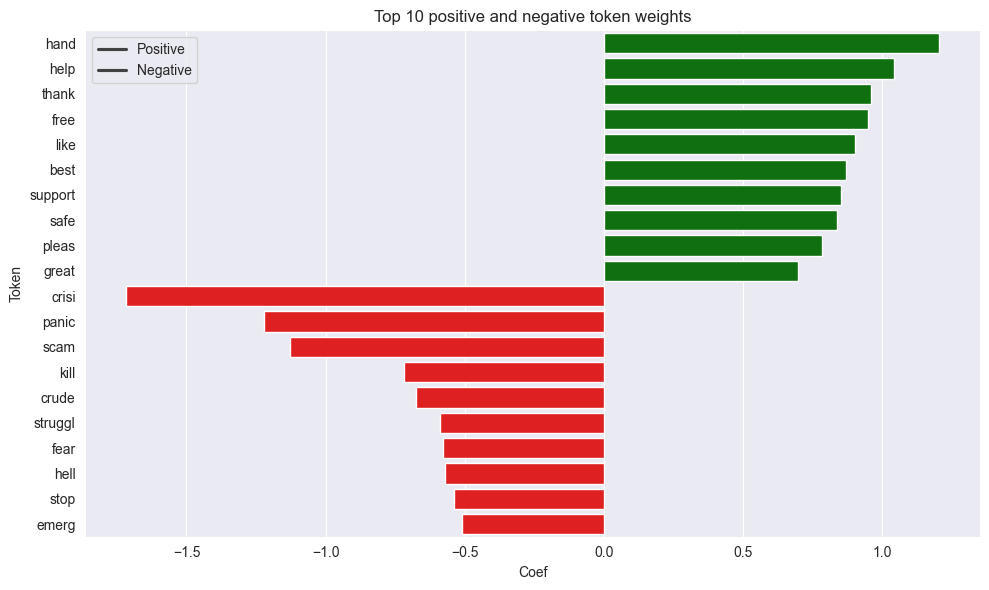

In [77]:
feature_names = cv_df.get_feature_names_out()
coefs = logreg_cv.coef_[0]

top_positive_idx = np.argsort(coefs)[-10:]
top_negative_idx = np.argsort(coefs)[:10]

top_positive_tokens = [(feature_names[i], coefs[i]) for i in top_positive_idx][::-1]
top_negative_tokens = [(feature_names[i], coefs[i]) for i in top_negative_idx]

top_tokens = top_positive_tokens + top_negative_tokens
tokens, weights = zip(*top_tokens)

plt.figure(figsize=(10, 6))
sns.barplot(x=weights, y=tokens, hue=[1]*10 + [0]*10, palette={1: "green", 0: "red"})
plt.title("Top 10 positive and negative token weights")
plt.xlabel("Coef")
plt.ylabel("Token")
plt.legend(["Positive", "Negative"], loc="best")
plt.tight_layout()
plt.show()

**Ответ:** На графике отчётливо видно, что такие слова, как hand, help, thank, free, like - относятся к сильным "симптомам" положительно стилистически окрашенного текста, а crisi(s), panic, scam, kill и crude - наоборот, негативной окраски. В целом, логично, логрег за нас нашёл эти слова. Метрики примерно такие же, но капельку меньше, чем было у меня на "пике".

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
# -- YOUR CODE HERE --

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [ ]:
# -- YOUR CODE HERE --

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
# -- YOUR CODE HERE --

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
# -- YOUR CODE HERE --

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --